<a href="https://colab.research.google.com/github/ilham-mukti/Mencoba-Neural-Network/blob/main/Tugas_Akhir_Belajar_Machine_Learning_Untuk_Pemula.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Nama: Ilham Mukti

Email: ilhammukti49@gmail.com

Username: ilham_mukti https://www.dicoding.com/users/ilham_mukti

In [ ]:
!pip install jcopdl

In [35]:

import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.models import mobilenet_v2
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import make_grid

from tqdm.auto import tqdm
from jcopdl.callback import Callback, set_config
from jcopdl.layers import linear_block, conv_block

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import PIL
from PIL import Image

import pandas as pd
import numpy as np
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [31]:
images, labels = [], []
import os
for dirname, _, filenames in os.walk('/content/rockpaperscissors/'):
  for filename in filenames:
    images.append(os.path.join(dirname, filename).split('/')[-1]) # /folder/blabla/xxx.jpg
    labels.append(os.path.join(dirname, filename).split('/')[-2])
label2cat = np.unique(labels)

In [32]:
ints = np.arange(0, len(label2cat))
dicts = dict(zip(label2cat, ints))
dicts

{'paper': 0, 'rock': 1, 'rps-cv-images': 2, 'scissors': 3}

In [21]:
datas = pd.DataFrame({'image_id':images, 'label':labels})
datas.shape

(4377, 2)

In [28]:
PATH = '/content/rockpaperscissors/'
index = []
for i in range(len(datas)):
    try:
        Image.open(PATH + str(datas['label'].values[i]) + '/' + str(datas['image_id'].values[i]))
    
    except PIL.UnidentifiedImageError:
        index.append(i)

datas = datas.drop(index)
datas.shape

(4376, 2)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(datas['image_id'].values, datas['label'].values, 
    test_size=0.4, stratify=datas['label'].values, 
    random_state=24)
len(X_train), len(X_test)

(2625, 1751)

In [36]:
class customDataset(Dataset):
    def __init__(self, x, y, path, maps_label=dicts, transform=None):
        self.X = x
        self.y = y
        self.path = path
        self.dicts = maps_label
        self.transform = transform
        
    def __getitem__(self, idx):
        img = Image.open(self.path + str(self.y[idx]) + '/' + str(self.X[idx])).convert('RGB')
        label = self.y[idx]
        label = self.label_2_ints(label)
        
        if self.transform is not None:
            img = self.transform(img)
            
        return img, label
    
    def label_2_ints(self, x):
        label_id = None
        for key, values in self.dicts.items():
            if x == key:
                label_id = values
        return label_id
    
    def __len__(self):
        return len(self.X)

In [55]:
crop_size = 128
bs = 64
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(135),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
    ])
train_set = customDataset(X_train, y_train, PATH, transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=2)

test_set = customDataset(X_test, y_test, PATH, transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

In [49]:
feature, target = next(iter(trainloader))
feature.shape

torch.Size([64, 3, 128, 128])

In [50]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
          conv_block(3, 8),
          conv_block(8, 16),
          conv_block(16, 32),
          conv_block(32, 64),
          conv_block(64, 128),
          nn.Flatten()
      )
    self.fc = nn.Sequential(
          linear_block(128*4*4, 256, dropout=0.2), #1024 dapet dari 64x4x4
          linear_block(256, 4, activation='lsoftmax')
      )
  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

In [51]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size
})

In [52]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, early_stop_patience=4, plot_every=10, outdir='model')

In [53]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == 'train':
    model.train()
  elif mode == 'test':
    model.eval()
  
  cost = correct = 0
  for feature, target in tqdm(dataloader, desc=mode.title()):
    feature, target = feature.to(device), target.to(device)
    output = model(feature)
    loss = criterion(output, target)

    if mode == 'train':
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    cost += loss.item() * feature.shape[0]
    correct += (output.argmax(1) == target).sum().item()
  cost = cost/len(dataset)
  acc = correct/len(dataset)
  return cost, acc



Epoch     1
Train_cost  = 1.1252 | Test_cost  = 1.1069 | Train_score = 0.3204 | Test_score = 0.3318 |




Epoch     2
Train_cost  = 1.1140 | Test_cost  = 1.1047 | Train_score = 0.3375 | Test_score = 0.3255 |
==> EarlyStop patience =  1 | Best test_score: 0.3318




Epoch     3
Train_cost  = 1.1057 | Test_cost  = 1.0983 | Train_score = 0.3356 | Test_score = 0.3255 |
==> EarlyStop patience =  2 | Best test_score: 0.3318




Epoch     4
Train_cost  = 1.1021 | Test_cost  = 1.0889 | Train_score = 0.3436 | Test_score = 0.3427 |




Epoch     5
Train_cost  = 0.9111 | Test_cost  = 0.7068 | Train_score = 0.5524 | Test_score = 0.6082 |




Epoch     6
Train_cost  = 0.4416 | Test_cost  = 0.4469 | Train_score = 0.8457 | Test_score = 0.8327 |




Epoch     7
Train_cost  = 0.1806 | Test_cost  = 0.3653 | Train_score = 0.9451 | Test_score = 0.8778 |




Epoch     8
Train_cost  = 0.1336 | Test_cost  = 0.3125 | Train_score = 0.9615 | Test_score = 0.9121 |




Epoch     9
Train_cost  = 0.1063 | Test_cost  = 0.1312 | Train_score = 0.9703 | Test_score = 0.9652 |




Epoch    10
Train_cost  = 0.1332 | Test_cost  = 0.2411 | Train_score = 0.9604 | Test_score = 0.9429 |


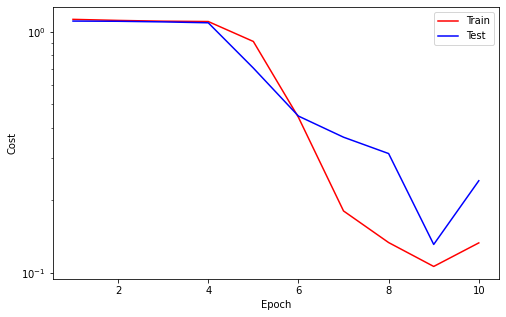

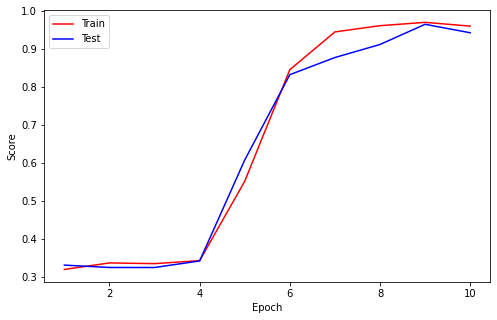

==> EarlyStop patience =  1 | Best test_score: 0.9652




Epoch    11
Train_cost  = 0.1096 | Test_cost  = 0.3358 | Train_score = 0.9676 | Test_score = 0.9063 |
==> EarlyStop patience =  2 | Best test_score: 0.9652




Epoch    12
Train_cost  = 0.0776 | Test_cost  = 0.1891 | Train_score = 0.9798 | Test_score = 0.9463 |
==> EarlyStop patience =  3 | Best test_score: 0.9652




Epoch    13
Train_cost  = 0.0750 | Test_cost  = 0.1512 | Train_score = 0.9821 | Test_score = 0.9577 |
==> EarlyStop patience =  4 | Best test_score: 0.9652
==> Execute Early Stopping at epoch: 13 | Best test_score: 0.9652
==> Best model is saved at model


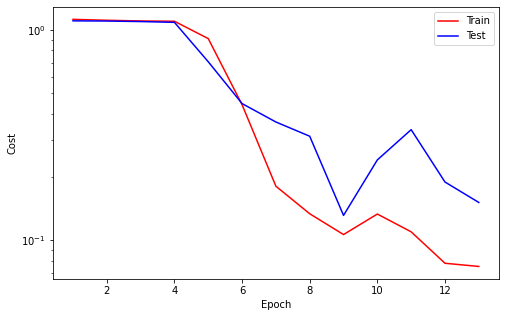

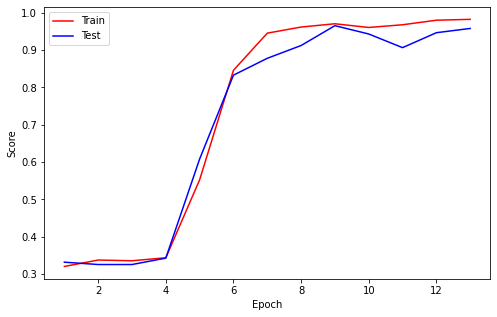

In [56]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
    test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  # Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  # Checkpoint
  callback.save_checkpoint()

  # Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  # Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

In [57]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds

tensor([1, 1, 1, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 0, 0, 3, 1, 3, 1, 3, 3, 1, 3, 0,
        1, 0, 0, 0, 1, 0, 3, 3, 0, 3, 1, 1, 1, 0, 0, 1, 3, 0, 1, 0, 0, 0, 0, 0,
        3, 1, 1, 3, 3, 3, 3, 1, 0, 3, 3, 3, 3, 0, 0, 0], device='cuda:0')

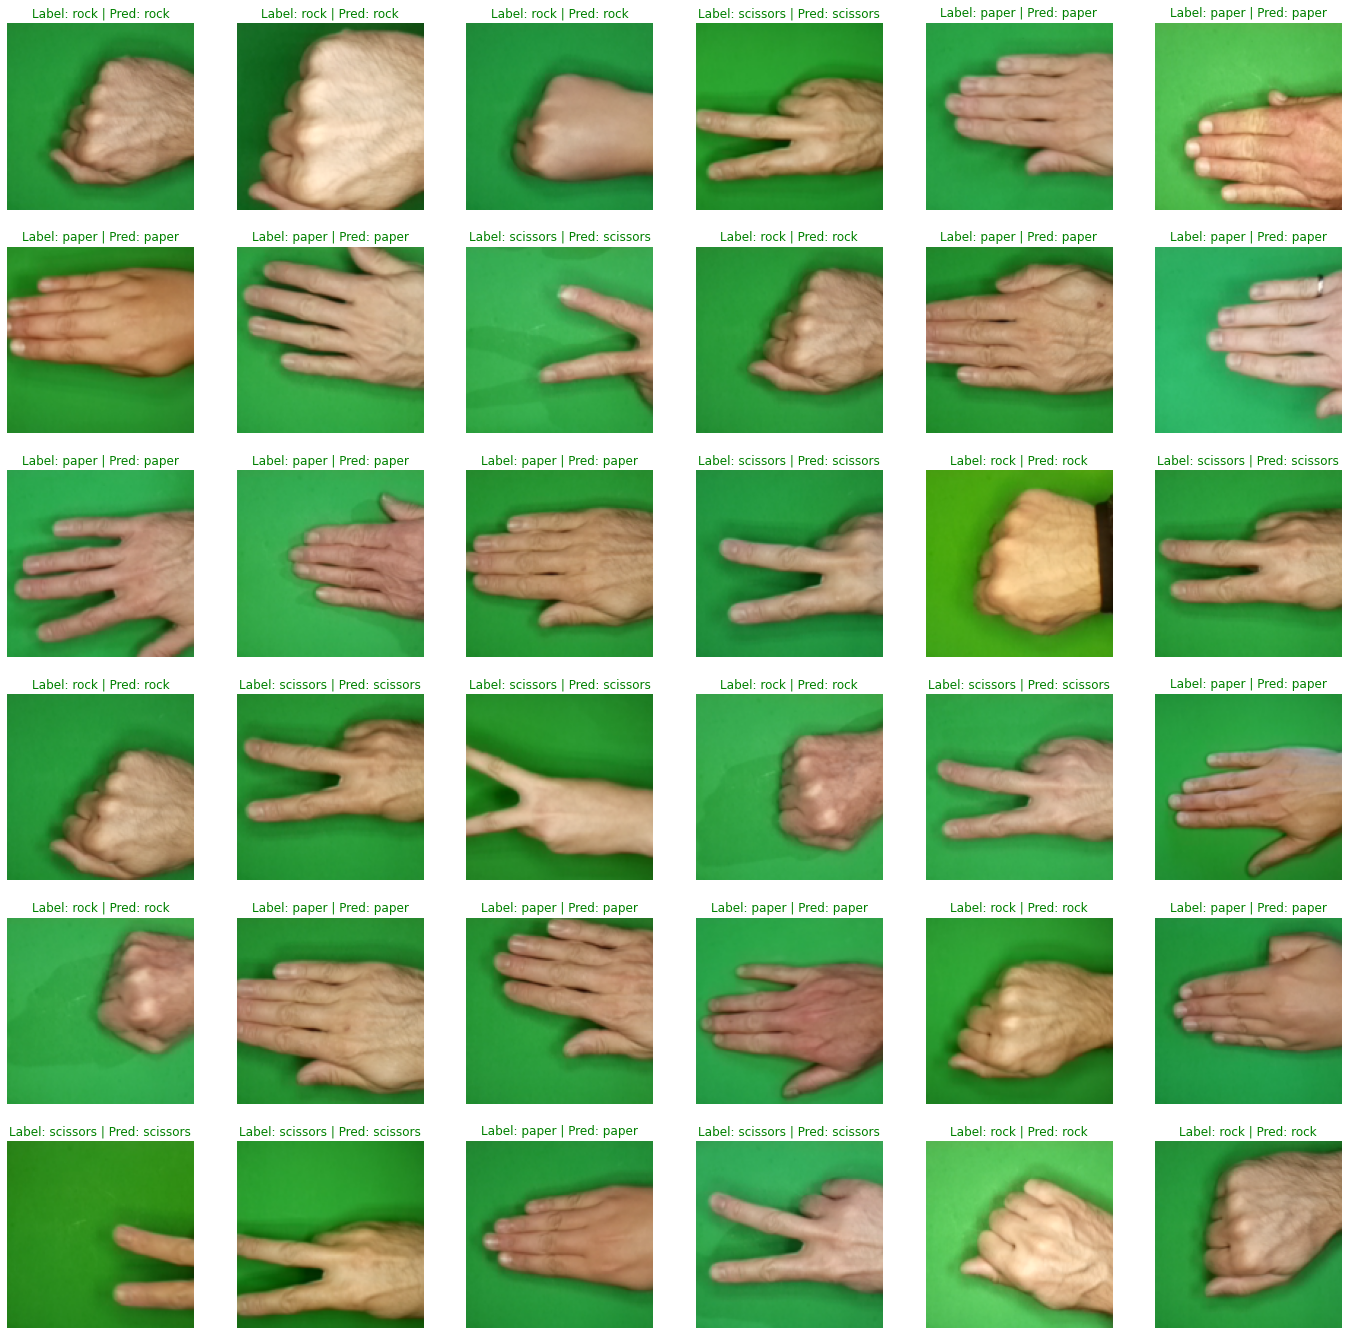

In [58]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for img, label, pred, ax in zip(feature, target, preds, axes.flatten()):
  ax.imshow(img.permute(1,2,0).cpu())
  font = {"color":'r'} if label != pred else {"color": 'g'}
  label, pred = label2cat[label.item()], label2cat[pred.item()]
  ax.set_title(f"Label: {label} | Pred: {pred}", fontdict=font);
  ax.axis("off");